In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime

import xesmf as xe
import scipy.signal as signal
import scipy.stats as st
import xgcm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean
import cmaps

from glob import glob
import sys
sys.path.append('../')
from utils import *
from load import *
from numerics import *
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=15, threads_per_worker=1)
client  = Client(cluster, asynchronous=True)
client


2023-04-28 09:23:07,430 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-49qqgvfj', purging
2023-04-28 09:23:07,431 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ovd0bujl', purging
2023-04-28 09:23:07,431 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-59fkqv53', purging
2023-04-28 09:23:07,432 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-h0xtid72', purging
2023-04-28 09:23:07,432 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-p9dygvst', purging
2023-04-28 09:23:07,432 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-tu1hbqu3', purging
2023-04-28 09:23:07,433 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-7a7md9b4', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 15
Total threads: 15,Total memory: 93.09 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38247,Workers: 15
Dashboard: http://127.0.0.1:8787/status,Total threads: 15
Started: Just now,Total memory: 93.09 GiB
Comm: tcp://127.0.0.1:43025,Total threads: 1
Dashboard: http://127.0.0.1:46165/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:40301,


In [2]:
import geopandas as gpd
coastline = gpd.read_file('~/storage/VECTORIAL/limites/chilecontinental.gpkg')
# Load grid
gridd1 = xr.open_dataset('~/storage/SEQUIA/crocod1_grd.nc').load()

/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/geopandas/geodataframe.py:639: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
# Load control simulation 
pathsavg_control = sorted(glob('data/DESALADORAS_RUND1/*avg*'))
control_avg      = xr.open_mfdataset(pathsavg_control, parallel=True)
control_avg      = fix_crocotime(control_avg, YORIG='1949-12-30 23:59:50')
control_avg      = center_crocogrid(control_avg, control_avg.keys())

In [251]:
#load sst and time series for tongoy and coquimbo pixel
sst = control_avg.temp.isel(s_rho=-1).load()
control_tongoy   = croco_selpoint(control_avg[['temp','salt','zeta','h']], 360-71.561582, -30.275075).load()
control_coquimbo = croco_selpoint(control_avg[['temp','zeta','h']], 360-71.316, -29.942).load()
control_cosmos   = croco_selpoint(control_avg[['u','v','h','zeta','temp']], 360-71.973, -30.33345).load()

2023-04-28 10:45:03,476 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.74 GiB -- Worker memory limit: 6.21 GiB
2023-04-28 10:45:25,927 - distributed.worker_memory - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 5.29 GiB -- Worker memory limit: 6.21 GiB
2023-04-28 10:45:26,742 - distributed.worker_memory - WARNING - Worker is at 73% memory usage. Resuming worker. Process memory: 4.56 GiB -- Worker memory limit: 6.21 GiB
2023-04-28 10:47:48,471 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:42081 (pid=25448) exceeded 95% memory budget. Restarting...
2023-04-28 10:47:48,724 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:36667 -> tcp://127.0.0.1:42081
Traceback (most recent call la

KeyboardInterrupt: 

Task exception was never retrieved
future: <Task finished name='Task-1112529' coro=<Client._gather.<locals>.wait() done, defined at /home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/distributed/client.py:2002> exception=AllExit()>
Traceback (most recent call last):
  File "/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/distributed/client.py", line 2011, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1112522' coro=<Client._gather.<locals>.wait() done, defined at /home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/distributed/client.py:2002> exception=AllExit()>
Traceback (most recent call last):
  File "/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/distributed/client.py", line 2011, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1112502' coro=<Client._gather.<locals>.wait() done, def

In [ ]:
control_cosmos['z_rho'] = rhopoints_depths(control_cosmos.h.expand_dims(dim={'s_rho':control_avg.s_rho}), control_cosmos.zeta, control_avg.s_rho, control_avg.Cs_r, control_avg.hc).load()
control_tongoy['z_rho'] = rhopoints_depths(control_tongoy.h.expand_dims(dim={'s_rho':control_avg.s_rho}), control_tongoy.zeta, control_avg.s_rho, control_avg.Cs_r, control_avg.hc).load()

In [ ]:
# For tongoy interpolate to 10m depth
# Interpolate coastal salinities from sigma coordinates to z coordinates
from xgcm import Grid
target_depths = np.array([10])


husk = Grid(control_tongoy, coords={'z':{'center':'s_rho'}}, periodic=False)
control_tongoy_temp = husk.transform(control_tongoy['temp'],'z',-target_depths, target_data=control_tongoy['z_rho'], method='linear', mask_edges=False)
control_tongoy_salt = husk.transform(control_tongoy['salt'],'z',-target_depths, target_data=control_tongoy['z_rho'], method='linear', mask_edges=False)

target_depths = np.hstack([np.arange(0,115,5), np.arange(120,760,10)])
husk = Grid(control_cosmos, coords={'z':{'center':'s_rho'}}, periodic=False)
control_cosmos_u = husk.transform(control_cosmos['u'],'z',-target_depths, target_data=control_cosmos['z_rho'], method='linear', mask_edges=False)
control_cosmos_v = husk.transform(control_cosmos['v'],'z',-target_depths, target_data=control_cosmos['z_rho'], method='linear', mask_edges=False)
control_cosmos_temp = husk.transform(control_cosmos['temp'],'z',-target_depths, target_data=control_cosmos['z_rho'], method='linear', mask_edges=False)


In [10]:
# load stations time series
coquimbo = [pd.read_csv(p, parse_dates=True, index_col=0) for p in glob('/home/lucasg/storage/ESTACIONES/*.csv')]
coquimbo = pd.concat(coquimbo, axis=1)#['2001':'2006']

tongoy_temp = pd.read_csv('/home/lucasg/storage/ESTACIONES/TongoyBalsaCMET/TongoyBalsaCMET_TemperaturadelAgua_BTGTAG.csv', skiprows=4, index_col=1, parse_dates=True)['prom']
tongoy_salt = pd.read_csv('/home/lucasg/storage/ESTACIONES/TongoyBalsaCMET/TongoyBalsaCMET_Salinidaddelagua_BTGSAL.csv', skiprows=4, index_col=1, parse_dates=True)['prom']

In [25]:
# load moorings
u_cosmos = pd.read_csv('/home/lucasg/storage/Anclajes/Cosmos/u.csv', index_col=0, parse_dates=True)['2001':'2006']
v_cosmos = pd.read_csv('/home/lucasg/storage/Anclajes/Cosmos/v.csv', index_col=0, parse_dates=True)['2001':'2006']

u_cosmos.columns = [int(str(v).replace('z','')) for v in u_cosmos.columns]
v_cosmos.columns = [int(str(v).replace('z','')) for v in v_cosmos.columns]

In [12]:
# Simple Quality control
coquimbo['NM[m]'] = coquimbo['NM[m]']-coquimbo['NM[m]'].mean()
coquimbo['NM[m]'] = coquimbo['NM[m]'].where(abs(coquimbo['NM[m]'])<coquimbo['NM[m]'].std()*3)

tongoy_salt       = tongoy_salt.where(tongoy_salt>34)

<xarray.DataArray 'temp' (time: 7671)>
array([17.25932 , 17.25932 , 17.25932 , ..., 17.194145, 17.194145,
       17.194145], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
    xi_rho   float32 128.0
    eta_rho  float32 349.0
    s_rho    float32 -0.01
    lon_rho  float32 288.7
    lat_rho  float32 -29.95
Attributes:
    long_name:      averaged potential temperature
    units:          Celsius
    field:          temperature, scalar, series
    standard_name:  sea_water_potential_temperature

Text(0.0, 1.0, 'MBIAS: 0.325\nRMSE:  1.337\nR2:       0.560')

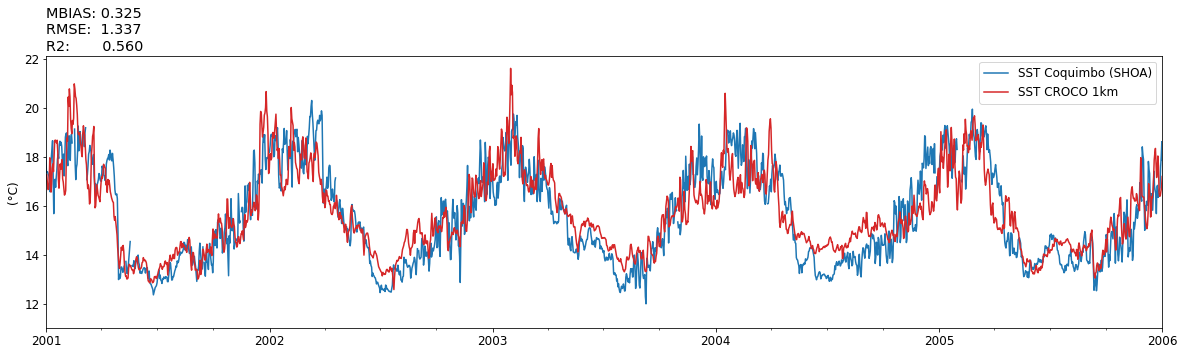

In [250]:
from scipy.stats import pearsonr
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(20,5))
x = control_coquimbo.temp.isel(s_rho=-1).reindex({'time':coquimbo['TSM[°C]']['2001':'2006'].resample('d').mean().dropna().index}, method='nearest').to_series()
y = coquimbo['TSM[°C]'].resample('d').mean().dropna()['2001':'2006']

(coquimbo['TSM[°C]'].resample('d').mean()).plot(ax=ax, label='SST Coquimbo (SHOA)')
ax.plot(control_coquimbo.time, control_coquimbo.temp.isel(s_rho=-1), color='tab:red', label='SST CROCO 1km')
ax.set_xlim(pd.to_datetime('2001'),pd.to_datetime('2006'))
ax.set_xlabel('')
ax.legend()
ax.set_ylabel('(°C)')

ax.set_title('MBIAS: {:.3f}\nRMSE:  {:.3f}\nR2:       {:.3f}'.format((x-y).mean(),((x-y)**2).mean()**0.5,pearsonr(x,y)[0]**2),
             loc='left')


Text(0, 0.5, '10m Salinity (PSU)')

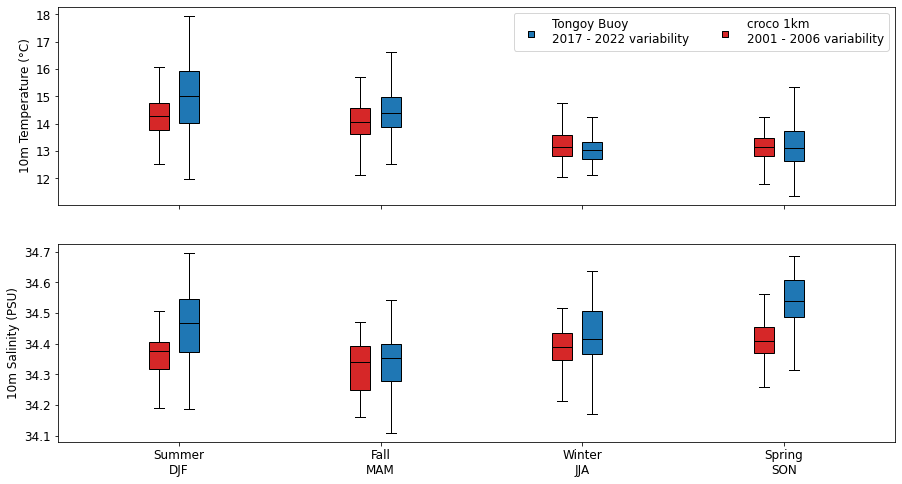

In [203]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(15,8))
x  = dict(control_tongoy_temp.isel(z_rho=0).groupby('time.season'))
xx = dict(tongoy_temp.resample('d').mean().to_xarray().groupby('ultima_lectura.season'))
y  = dict(control_tongoy_salt.isel(z_rho=0).groupby('time.season'))
yy = dict(tongoy_salt.resample('d').mean().to_xarray().groupby('ultima_lectura.season'))
for i,s in enumerate(['DJF','MAM','JJA','SON']):
    ax[0].boxplot(x[s], positions=[i-0.1], sym='', patch_artist=True, boxprops={'facecolor':'tab:red'}, medianprops={'color':'k'}, widths=0.1)
    ax[0].boxplot(xx[s].dropna('ultima_lectura'), positions=[i+0.05], sym='', patch_artist=True, boxprops={'facecolor':'tab:blue'}, medianprops={'color':'k'}, widths=0.1)
    
    ax[1].boxplot(y[s], positions=[i-0.1], sym='', patch_artist=True, boxprops={'facecolor':'tab:red'}, medianprops={'color':'k'}, widths=0.1)
    ax[1].boxplot(yy[s].dropna('ultima_lectura'), positions=[i+0.05], sym='', patch_artist=True, boxprops={'facecolor':'tab:blue'}, medianprops={'color':'k'}, widths=0.1)
    
ax[0].set_xticks(np.arange(4))
ax[0].set_xticklabels(['Summer\nDJF','Fall\nMAM','Winter\nJJA','Spring\nSON'])

ax[0].scatter([],[],color='tab:blue', label='Tongoy Buoy\n2017 - 2022 variability', marker='s', ec='k')
ax[0].scatter([],[],color='tab:red', label='croco 1km\n2001 - 2006 variability', marker='s', ec='k')

ax[0].legend(ncol=2)
ax[0].set_ylabel('10m Temperature (°C)')
ax[1].set_ylabel('10m Salinity (PSU)')

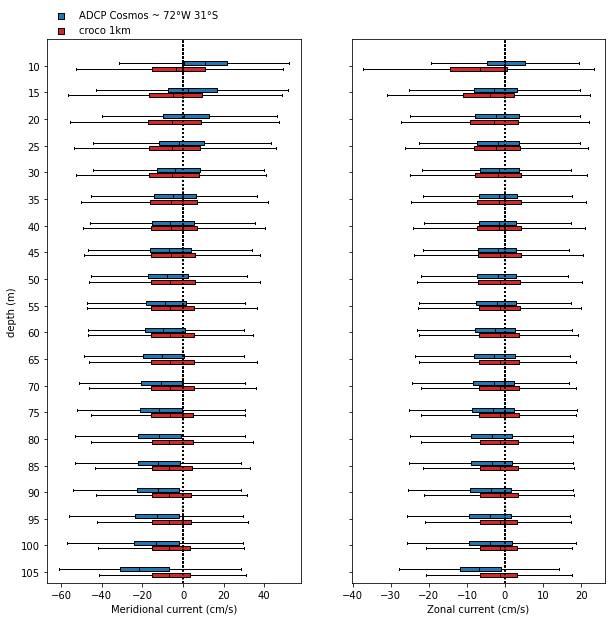

In [170]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,10))

for i,z in enumerate(v_cosmos.columns):
    ax[0].axvline(0, color='k', ls=':')
    ax[1].axvline(0, color='k', ls=':')
    
    ax[0].boxplot(v_cosmos[z].resample('d').mean().dropna(), positions=[z-0.5], vert=False, sym='', widths=0.75, patch_artist=True, boxprops={'facecolor':'tab:blue'}, medianprops={'color':'k'})
    ax[0].boxplot(control_cosmos_v.sel(z_rho=-z).values*100, positions=[z+0.5], vert=False, sym='', widths=0.75, patch_artist=True, boxprops={'facecolor':'tab:red'}, medianprops={'color':'k'})
    
    
    ax[1].boxplot(u_cosmos[z].resample('d').mean().dropna(), positions=[z-0.5], vert=False, sym='', widths=0.75, patch_artist=True, boxprops={'facecolor':'tab:blue'}, medianprops={'color':'k'})
    ax[1].boxplot(control_cosmos_u.sel(z_rho=-z).values*100, positions=[z+0.5], vert=False, sym='', widths=0.75, patch_artist=True, boxprops={'facecolor':'tab:red'}, medianprops={'color':'k'})
    


ax[0].set_yticks(v_cosmos.columns);
ax[0].set_yticklabels(v_cosmos.columns);

ax[0].set_ylim(107,5)

ax[0].set_ylabel('depth (m)')
ax[0].set_xlabel('Meridional current (cm/s)')
ax[1].set_xlabel('Zonal current (cm/s)')

ax[0].scatter([],[],color='tab:blue', label='ADCP Cosmos ~ 72°W 31°S', marker='s', ec='k')
ax[0].scatter([],[],color='tab:red', label='croco 1km', marker='s', ec='k')

ax[0].legend(loc=(0,1), frameon=False)

Text(0.0, 1.0, 'Period: 2001-01  -  2005-12\n')

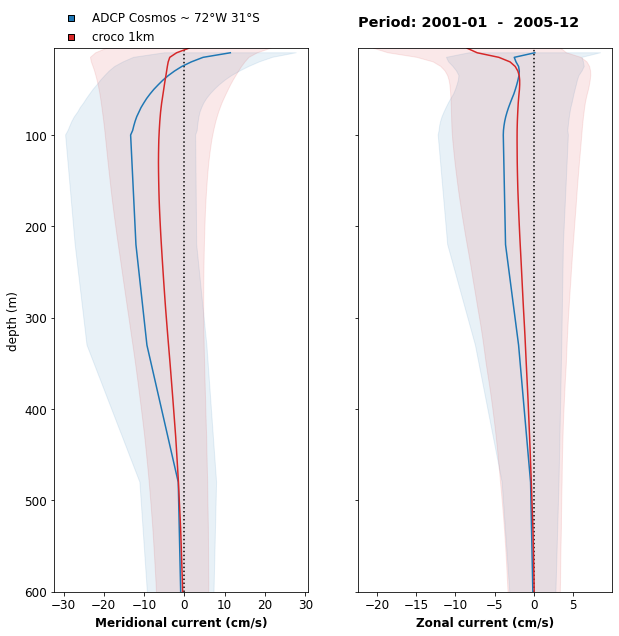

In [252]:
plt.rc('font', size=12)
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,10))
ax[0].axvline(0, color='k', ls=':')
ax[1].axvline(0, color='k', ls=':')


x = v_cosmos.drop([110,105], axis=1).resample('d').mean()
ax[0].plot(x.mean(),x.columns)
ax[0].fill_betweenx(x.columns, x.mean()-x.std(), x.mean()+x.std(), color='tab:blue', alpha=0.1)
ax[0].plot(control_cosmos_v.mean('time')*100,-control_cosmos_v.z_rho, color='tab:red')
ax[0].fill_betweenx(-control_cosmos_v.z_rho,
                    control_cosmos_v.mean('time')*100-control_cosmos_v.std('time')*100,
                    control_cosmos_v.mean('time')*100+control_cosmos_v.std('time')*100,
                    alpha=0.1, color='tab:red')

y = u_cosmos.drop([110,105], axis=1).resample('d').mean()
ax[1].plot(y.mean(),y.columns)
ax[1].fill_betweenx(y.columns, y.mean()-y.std(), y.mean()+y.std(), color='tab:blue', alpha=0.1)
ax[1].plot(control_cosmos_u.mean('time')*100,-control_cosmos_v.z_rho, color='tab:red')
ax[1].fill_betweenx(-control_cosmos_v.z_rho,
                    control_cosmos_u.mean('time')*100-control_cosmos_u.std('time')*100,
                    control_cosmos_u.mean('time')*100+control_cosmos_u.std('time')*100,
                    alpha=0.1, color='tab:red')




ax[0].set_ylim(600,5)

ax[0].set_ylabel('depth (m)')
ax[0].set_xlabel('Meridional current (cm/s)', weight='bold')
ax[1].set_xlabel('Zonal current (cm/s)', weight='bold')

ax[0].scatter([],[],color='tab:blue', label='ADCP Cosmos ~ 72°W 31°S', marker='s', ec='k')
ax[0].scatter([],[],color='tab:red', label='croco 1km', marker='s', ec='k')

ax[0].legend(loc=(0,1), frameon=False,)

ax[1].set_title('Period: 2001-01  -  2005-12\n', weight='bold', loc='left')